In [36]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import numpy as np

# Fetch sidewalk data from NYC API
url = 'https://data.cityofnewyork.us/resource/52n9-sdep.json'
params = {
    '$where': 'intersects(the_geom, "POLYGON((-73.9927 40.7242, -73.9787 40.7202, -73.9756 40.7285, -73.9875 40.7325, -73.9927 40.7242))")',
    '$limit': 5000
}

response = requests.get(url, params=params)
data = response.json()

print(f"Fetched {len(data)} sidewalks")
print("Sample record:", data[0].keys())

Fetched 116 sidewalks
Sample record: dict_keys(['the_geom', 'source_id', 'sub_code', 'feat_code', 'status', 'shape_leng', 'shape_area'])


In [37]:
# Look at first sidewalk's geometry
sample = data[88]
print("Geometry type:", sample['the_geom']['type'])
print("Number of rings:", len(sample['the_geom']['coordinates'][0]))
print("Outer ring with", len(sample['the_geom']['coordinates'][0][0]), "points")

# Check if it has inner ring
if len(sample['the_geom']['coordinates'][0]) > 1:
    print("Has inner ring with", len(sample['the_geom']['coordinates'][0][1]), "points")

Geometry type: MultiPolygon
Number of rings: 2
Outer ring with 312 points
Has inner ring with 56 points


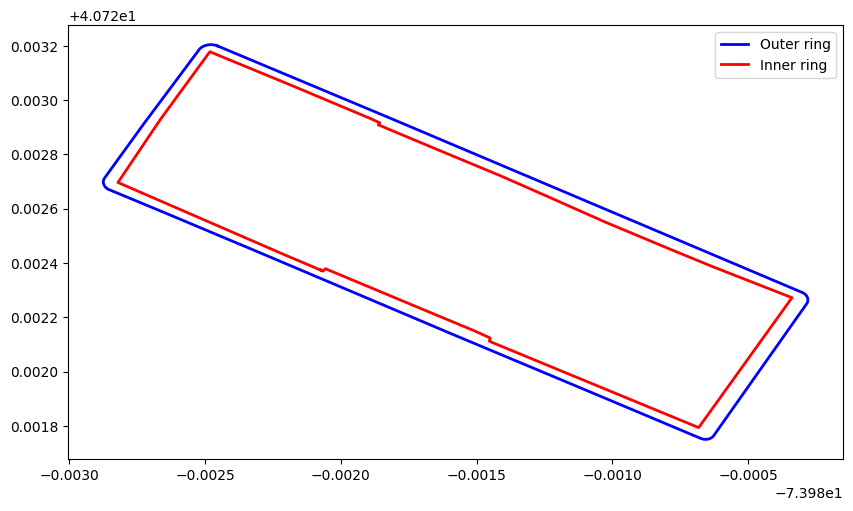

In [38]:
# Plot a single sidewalk
coords = data[88]['the_geom']['coordinates'][0]
outer_ring = coords[0]
inner_ring = coords[1] if len(coords) > 1 else None

fig, ax = plt.subplots(figsize=(10, 10))

# Plot outer ring
outer_x = [p[0] for p in outer_ring]
outer_y = [p[1] for p in outer_ring]
ax.plot(outer_x, outer_y, 'b-', linewidth=2, label='Outer ring')

# Plot inner ring if exists
if inner_ring:
    inner_x = [p[0] for p in inner_ring]
    inner_y = [p[1] for p in inner_ring]
    ax.plot(inner_x, inner_y, 'r-', linewidth=2, label='Inner ring')

ax.legend()
ax.set_aspect('equal')
plt.show()

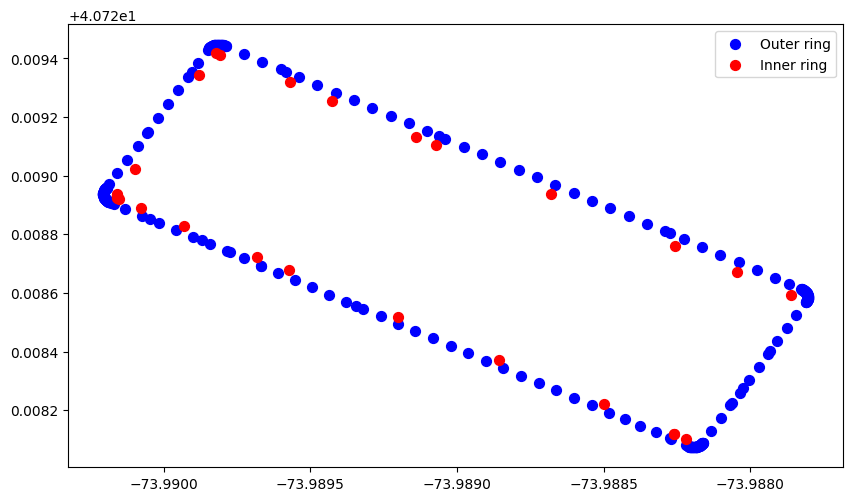

In [50]:
# Plot a single sidewalk with points only
coords = data[37]['the_geom']['coordinates'][0]
outer_ring = coords[0]
inner_ring = coords[1] if len(coords) > 1 else None

fig, ax = plt.subplots(figsize=(10, 10))

# Plot outer ring as points
outer_x = [p[0] for p in outer_ring]
outer_y = [p[1] for p in outer_ring]
ax.scatter(outer_x, outer_y, c='blue', s=50, label='Outer ring')

# Plot inner ring if exists
if inner_ring:
    inner_x = [p[0] for p in inner_ring]
    inner_y = [p[1] for p in inner_ring]
    ax.scatter(inner_x, inner_y, c='red', s=50, label='Inner ring')

ax.legend()
ax.set_aspect('equal')
plt.show()

Created centerline with 100 points
Split into 9 directional segments
E: min=7.0ft, avg=67.5ft
S: min=1.5ft, avg=12.7ft
W: min=9.6ft, avg=11.5ft
N: min=3.4ft, avg=9.2ft
W: min=13.9ft, avg=67.8ft
N: min=2.6ft, avg=12.7ft
E: min=11.3ft, avg=12.2ft
S: min=0.4ft, avg=8.2ft
E: min=15.1ft, avg=21.0ft


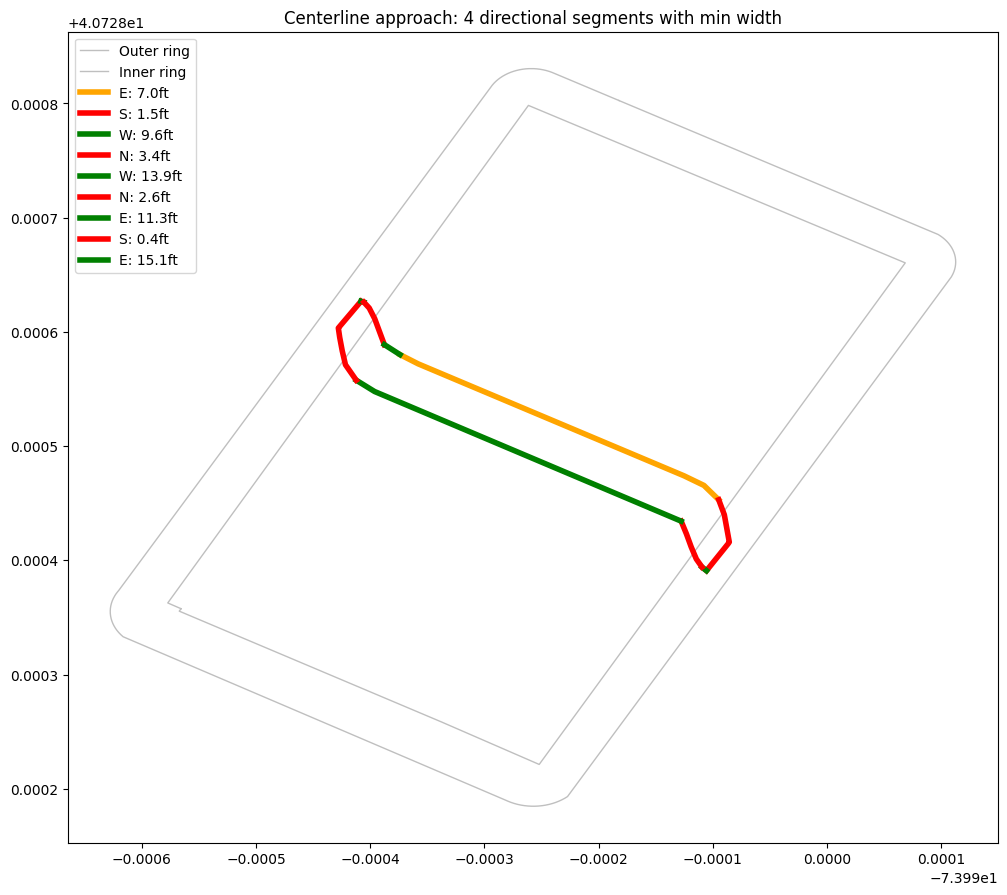

In [32]:
from shapely.geometry import LineString, Point as ShapelyPoint
from shapely.ops import substring
import numpy as np

def create_centerline(outer_ring, inner_ring, num_samples=100):
    """Create centerline between outer and inner rings"""
    outer_line = LineString(outer_ring)
    inner_line = LineString(inner_ring)
    
    centerline_points = []
    
    for i in range(num_samples):
        frac = i / (num_samples - 1)
        
        outer_pt = outer_line.interpolate(frac, normalized=True)
        inner_pt = inner_line.interpolate(frac, normalized=True)
        
        # Midpoint
        centerline_points.append([
            (outer_pt.x + inner_pt.x) / 2,
            (outer_pt.y + inner_pt.y) / 2
        ])
    
    return centerline_points

def segment_centerline_by_direction(centerline_points):
    """Split centerline into 4 directional segments"""
    if len(centerline_points) < 4:
        return []
    
    segments = []
    current_segment = [centerline_points[0]]
    current_direction = None
    
    for i in range(len(centerline_points) - 1):
        direction = get_direction(centerline_points[i], centerline_points[i+1])
        
        if current_direction is None:
            current_direction = direction
        
        if direction == current_direction:
            current_segment.append(centerline_points[i+1])
        else:
            if len(current_segment) >= 2:
                segments.append({
                    'points': current_segment,
                    'direction': current_direction
                })
            current_segment = [centerline_points[i], centerline_points[i+1]]
            current_direction = direction
    
    # Add final segment
    if len(current_segment) >= 2:
        segments.append({
            'points': current_segment,
            'direction': current_direction
        })
    
    return segments

def calculate_min_width_for_centerline(centerline_segment, outer_ring, inner_ring):
    """For each point on centerline, find min distance to either ring"""
    outer_line = LineString(outer_ring)
    inner_line = LineString(inner_ring)
    
    widths = []
    
    for point in centerline_segment:
        pt = ShapelyPoint(point)
        
        # Distance to outer ring
        dist_outer = pt.distance(outer_line) * 364000
        
        # Distance to inner ring
        dist_inner = pt.distance(inner_line) * 364000
        
        # Width = 2x the minimum distance (distance to nearest edge)
        width = 2 * min(dist_outer, dist_inner)
        widths.append(width)
    
    return {
        'widths': widths,
        'min_width': min(widths),
        'avg_width': sum(widths) / len(widths)
    }

# MAIN PROCESS
def process_sidewalk_centerline_approach(sidewalk_data):
    """Process sidewalk using centerline approach"""
    coords = sidewalk_data['the_geom']['coordinates'][0]
    outer_ring = coords[0]
    inner_ring = coords[1] if len(coords) > 1 else None
    
    if not inner_ring:
        return None
    
    # Step 1: Create centerline
    centerline = create_centerline(outer_ring, inner_ring, num_samples=100)
    print(f"Created centerline with {len(centerline)} points")
    
    # Step 2: Segment by direction
    segments = segment_centerline_by_direction(centerline)
    print(f"Split into {len(segments)} directional segments")
    
    # Step 3: Calculate width for each segment
    results = []
    
    for seg in segments:
        width_data = calculate_min_width_for_centerline(
            seg['points'], 
            outer_ring, 
            inner_ring
        )
        
        results.append({
            'direction': seg['direction'],
            'centerline': seg['points'],
            'min_width': width_data['min_width'],
            'avg_width': width_data['avg_width']
        })
        
        print(f"{seg['direction']}: min={width_data['min_width']:.1f}ft, avg={width_data['avg_width']:.1f}ft")
    
    return results

# Test it
test_sidewalk = None
for sw in data[:20]:
    coords = sw['the_geom']['coordinates'][0]
    if len(coords) > 1:
        test_sidewalk = sw
        break

if test_sidewalk:
    results = process_sidewalk_centerline_approach(test_sidewalk)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot original polygon
    coords = test_sidewalk['the_geom']['coordinates'][0]
    ox, oy = zip(*coords[0])
    ax.plot(ox, oy, 'gray', linewidth=1, alpha=0.5, label='Outer ring')
    
    if len(coords) > 1:
        ix, iy = zip(*coords[1])
        ax.plot(ix, iy, 'gray', linewidth=1, alpha=0.5, label='Inner ring')
    
    # Plot centerline segments colored by width
    colors_by_width = {
        'narrow': 'red',
        'mid': 'orange', 
        'wide': 'green'
    }
    
    if results:
        for r in results:
            cx = [p[0] for p in r['centerline']]
            cy = [p[1] for p in r['centerline']]
            
            # Categorize
            if r['min_width'] < 6.5:
                cat = 'narrow'
            elif r['min_width'] <= 8.5:
                cat = 'mid'
            else:
                cat = 'wide'
            
            ax.plot(cx, cy, color=colors_by_width[cat], linewidth=4, 
                   label=f"{r['direction']}: {r['min_width']:.1f}ft")
    
    ax.set_aspect('equal')
    ax.legend()
    ax.set_title('Centerline approach: 4 directional segments with min width')
    plt.show()

In [34]:
def simple_width_approach(outer_ring, inner_ring):
    """Sample outer ring, measure to inner, segment by direction"""
    outer_line = LineString(outer_ring)
    inner_line = LineString(inner_ring)
    
    samples = []
    for i in range(100):
        frac = i / 99
        outer_pt = outer_line.interpolate(frac, normalized=True)
        
        # Find nearest point on inner line
        nearest_inner = inner_line.interpolate(inner_line.project(outer_pt))
        
        width = outer_pt.distance(nearest_inner) * 364000
        direction = get_direction([outer_pt.x, outer_pt.y], [nearest_inner.x, nearest_inner.y])
        
        samples.append({
            'point': [outer_pt.x, outer_pt.y],
            'width': width,
            'direction': direction
        })
    
    return samples